In [1]:
from pathlib import Path

from astropy.coordinates import SkyCoord
from gammapy.data import FixedPointingInfo, Observation, observatory_locations
from gammapy.datasets import SpectrumDataset, SpectrumDatasetOnOff
from gammapy.estimators import SensitivityEstimator
from gammapy.irf import (
    Background3D,
    EnergyDispersion2D,
    RadMax2D,
    load_irf_dict_from_file,
)
from gammapy.makers import SpectrumDatasetMaker
from gammapy.maps import MapAxis, RegionGeom
from regions import CircleSkyRegion, PointSkyRegion

In [2]:
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
import uproot
from astropy.visualization import quantity_support

quantity_support();

In [3]:
prod5_irf_point_fits = "./IRFs/Prod5-South-20deg-SouthAz-14MSTs37SSTs.180000s_pointlike.fits"

In [4]:
irfs = load_irf_dict_from_file(prod5_irf_point_fits)
for key, irf in irfs.items():
    print(key, irf)

aeff EffectiveAreaTable2D
--------------------

  axes  : ['energy_true', 'offset']
  shape : (42, 6)
  ndim  : 2
  unit  : m2
  dtype : >f4

edisp EnergyDispersion2D
------------------

  axes  : ['energy_true', 'migra', 'offset']
  shape : (300, 300, 6)
  ndim  : 3
  unit  : 
  dtype : >f4

bkg Background2D
------------

  axes  : ['energy', 'offset']
  shape : (21, 6)
  ndim  : 2
  unit  : 1 / (MeV s sr)
  dtype : >f4

rad_max RadMax2D
--------

  axes  : ['energy', 'offset']
  shape : (500, 6)
  ndim  : 2
  unit  : deg
  dtype : >f4



The SpectrumMaker docs say it needs Background3D not Background2D so we can try converting here to see if that fixes things. 

Edit: no it does not

In [ ]:
#irfs['bkg']= irfs['bkg'].to_3d()
#irfs['bkg']

In [ ]:
#irfs['bkg'].peek()

In [6]:
reco_energy_bins = [
    0.012589254117941675,
    0.0199526231496888,
    0.03162277660168379,
    0.05011872336272722,
    0.07943282347242814,
    0.12589254117941667,
    0.1995262314968879,
    0.3162277660168378,
    0.501187233627272,
    0.7943282347242809,
    1.2589254117941662,
    1.9952623149688768,
    3.162277660168376,
    5.011872336272719,
    7.943282347242805,
    12.58925411794165,
    19.95262314968877,
    31.62277660168376,
    50.118723362727145,
    79.43282347242797,
    125.89254117941648,
    199.52623149688787,
] * u.TeV
conf = {}
location = observatory_locations["cta_south"]
livetime = conf.get("livetime", 50.0 * u.h)

In [7]:
energy_axis_reco = MapAxis.from_nodes(
    reco_energy_bins, interp="log", name="energy"
).to_node_type("edges")

energy_axis_true = MapAxis.from_energy_bounds(
    conf.get("E_true_min", 0.01 * u.TeV),
    conf.get("E_true_max", 350 * u.TeV),
    nbin=conf.get("E_true_nbin", 150),
    name="energy_true",
)
pointing = SkyCoord(
    ra=conf.get("point_ra", 0 * u.deg), dec=conf.get("point_dec", 0 * u.deg)
)
offset = conf.get("point_offset", 0.5 * u.deg)
offset_dir = conf.get("point_offset_dir", 0.0 * u.deg)

pointing_info = FixedPointingInfo(fixed_icrs=pointing)
source_position = pointing.directional_offset_by(offset_dir, offset)
on_region = PointSkyRegion(source_position)

In [8]:
print(f"{pointing_info=}")
print(f"{source_position=}")
print(f"{on_region=}")

pointing_info=<gammapy.data.pointing.FixedPointingInfo object at 0x1530a0950>
source_position=<SkyCoord (ICRS): (ra, dec) in deg
    (0., 0.5)>
on_region=<PointSkyRegion(center=<SkyCoord (ICRS): (ra, dec) in deg
    (0., 0.5)>)>


In [9]:
geom = RegionGeom.create(region=on_region, axes=[energy_axis_reco])
empty_dataset = SpectrumDataset.create(geom=geom, energy_axis_true=energy_axis_true)

print("geometry", geom)

geometry RegionGeom

	region     : PointSkyRegion
	axes       : ['lon', 'lat', 'energy']
	shape      : (1, 1, 22)
	ndim       : 3
	frame      : icrs
	center     : 0.0 deg, 0.5 deg



In [10]:
obs = Observation.create(
    pointing=pointing_info, irfs=irfs, livetime=livetime, location=location
)
obs

In [11]:
obs.rad_max

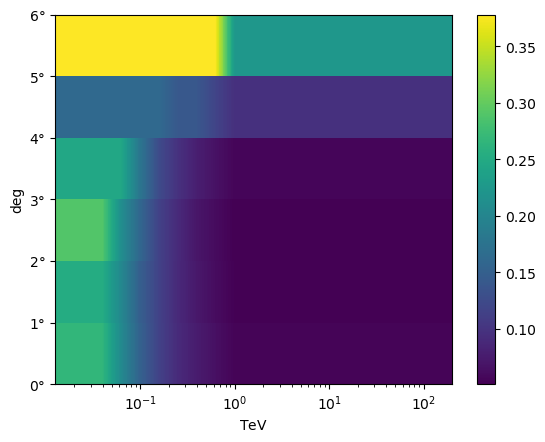

In [12]:
radmax = obs.rad_max.data.T
plt.semilogx()
plt.pcolormesh(
    obs.rad_max.axes[0].as_plot_edges, obs.rad_max.axes[1].as_plot_edges, radmax
)
plt.colorbar()

In [ ]:
irfs["bkg"].peek()

In [13]:
spectrum_maker = SpectrumDatasetMaker(
    selection=["exposure", "background","edisp"],
    containment_correction=False,
)
dataset = spectrum_maker.run(empty_dataset, obs)

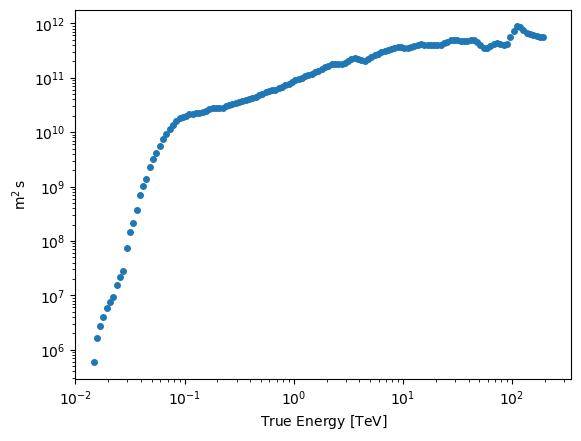

In [14]:
dataset.exposure.plot()
dataset

No background counts are computed for some reason. 

/Users/kkosack/miniconda3/envs/gammapy-1.2/lib/python3.11/site-packages/gammapy/maps/region/ndmap.py:130: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_yscale("log", nonpositive="clip")


<Axes: xlabel='Energy [$\\mathrm{TeV}$]', ylabel='$\\mathrm{}$'>

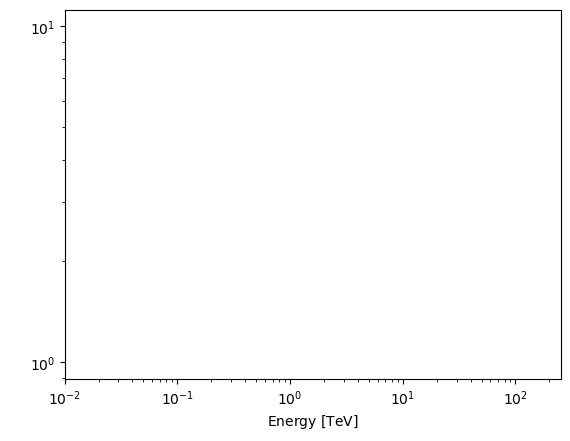

In [15]:
dataset.background.plot()

In [16]:
dataset_on_off = SpectrumDatasetOnOff.from_spectrum_dataset(
    dataset=dataset, acceptance=1, acceptance_off=5
)
dataset_on_off

/Users/kkosack/miniconda3/envs/gammapy-1.2/lib/python3.11/site-packages/gammapy/stats/counts_statistic.py:475: RuntimeWarning: invalid value encountered in scalar divide
  alpha = self.n_bkg.sum(axis=axis) / n_off
/Users/kkosack/miniconda3/envs/gammapy-1.2/lib/python3.11/site-packages/gammapy/stats/counts_statistic.py:475: RuntimeWarning: invalid value encountered in scalar divide
  alpha = self.n_bkg.sum(axis=axis) / n_off


In [17]:
sensitivity_estimator = SensitivityEstimator(
    gamma_min=10,
    n_sigma=5,
    bkg_syst_fraction=0.05,
)
gp_sensitivity_table = sensitivity_estimator.run(dataset_on_off)
gp_sensitivity_table

/Users/kkosack/miniconda3/envs/gammapy-1.2/lib/python3.11/site-packages/astropy/units/quantity.py:671: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


energy,e_ref,e_min,e_max,e2dnde,excess,background,criterion
TeV,TeV,TeV,TeV,erg / (s cm2),,,
float64,float64,float64,float64,float64,float64,float64,bytes12
0.0125893,0.0125893,0.01,0.0158489,inf,10,0,gamma
0.0199526,0.0199526,0.0158489,0.0251189,inf,10,0,gamma
0.0316228,0.0316228,0.0251189,0.0398107,3.63773e-12,10,0,gamma
0.0501187,0.0501187,0.0398107,0.0630957,9.58025e-14,10,0,gamma
0.0794328,0.0794328,0.0630957,0.1,1.70231e-14,10,0,gamma
0.125893,0.125893,0.1,0.158489,1.94857e-14,10,0,gamma
0.199526,0.199526,0.158489,0.251189,2.57517e-14,10,0,gamma
0.316228,0.316228,0.251189,0.398107,3.0329e-14,10,0,gamma
